In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import final_project_functions as fun
import time
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd

In [3]:
players = pd.read_csv("Data/players.csv")
players['height'] = players.height.apply(lambda cell: fun.fix_height(cell))

In [191]:
import pickle

In [192]:
games = pd.read_csv("Data/games.csv")
players = pd.read_csv("Data/players.csv")
plays = pd.read_csv("Data/plays.csv")
weeks = pd.read_csv("Data/week1.csv")
weeks['week'] = 1

for i in range(2, 18):
    week_temp = pd.read_csv("Data/week{}.csv".format(i))
    week_temp['week'] = i
    weeks = pd.merge(weeks, week_temp, how='outer')
    print(i)

OFFENSE = ['QB', 'RB', 'WR', 'TE', 'FB']

# Necessary to clean height data
players['height'] = players.height.apply(lambda cell: fun.fix_height(cell))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


- Measuring which players are the most effective at intercepting and sacking throughout the nfl, along with looking at stats such as the number of penalties and passes completed while they were on the field or against them to measure if they were responsible for the play

In [193]:
#weeks.to_pickle("all_weeks") 

In [318]:
#pd.read_pickle("all_weeks")

week_columns =['pass_forward', 'pass_arrived',
       'pass_outcome_caught',  'pass_outcome_incomplete',
       'tackle', 'play_action',
       'qb_sack', 'fumble', 'fumble_offense_recovered',
       'pass_tipped', 'pass_outcome_interception', 'qb_strip_sack',
       'touchdown',
       'fumble_defense_recovered', 'pass_outcome_touchdown',
        'penalty_flag', 'penalty_accepted']

In [195]:
players_extra = pd.read_csv("Data/playerInformation/players.csv")
combine = pd.read_csv("Data/playerInformation/combine.csv")
combine_extra = pd.read_csv("Data/playerInformation/combine_data_since_2000_PROCESSED_2018-04-26.csv")

In [319]:
fp = "Data/playerinformation/cb_2018_us_state_500k.shp"
map_df = gpd.read_file(fp)
map_df.head(2)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."


In [431]:
def fixDate(day):
    if day.count("-") >1:
        return int(day[:4])
    elif day.count("/") >1:
        return int(day[-4:])
    else:
        print(day)

In [432]:
players['birthYear'] = players['birthDate'].apply(lambda day: fixDate(day))
players['nflId'] = players.nflId.astype(str)

In [433]:
df_all_players = pd.merge(players, players_extra, on='nflId')#, how='outer', indicator=True)
all_players_cols = ['nflId', 'height', 'weight_x','combineId', 'birthDate', 'collegeName', 'position_x',
       'displayName', 'birthYear', 'playerId', 'nameFirst', 'nameLast', 'collegeId', 'college',
       'heightInches', 'dob', 'ageAtDraft',
       'homeCity', 'homeState', 'homeCountry', 'highSchool', 'hsCity',
       'hsState', 'hsCountry']
df_all_players = df_all_players.drop_duplicates()
df_all_players[all_players_cols].head(3)

,nflId,height,weight_x,combineId,birthDate,collegeName,position_x,displayName,birthYear,playerId,...,heightInches,dob,ageAtDraft,homeCity,homeState,homeCountry,highSchool,hsCity,hsState,hsCountry
0,2539334,72,190,18228.0,1990-09-10,Washington,CB,Desmond Trufant,1990,20130022,...,72.0,1990-09-10,22.638356,Tacoma,WA,USA,Woodrow Wilson HS,Tacoma,WA,USA
1,2539653,70,186,17976.0,1988-11-01,Southeastern Louisiana,CB,Robert Alford,1988,20130060,...,70.0,1988-11-01,24.495890,Hammond,LA,USA,Hammond HS,NaN,LA,USA
2,2543850,69,186,18270.0,1991-12-18,Purdue,SS,Ricardo Allen,1991,20140147,...,69.0,1991-12-18,22.402740,Daytona Beach,FL,USA,Mainland HS,Daytona Beach,FL,USA


In [434]:
combine_cols_add = ['combineYear', 'combinePosition',
       'combineHeight', 'combineWeight', 'combineHand','nflId',
       'combineArm', 'combine40yd', 'combineVert',
       'combineBench', 'combineShuttle', 'combineBroad', 'combine3cone',
       'combine60ydShuttle', 'combineWonderlic']
combine_new = combine[combine_cols_add]

In [435]:
df_comb = pd.merge(combine_new, df_all_players, on='nflId', how='outer', indicator=True)
df_full = df_comb[df_comb._merge == 'both']
df_missing = df_comb[df_comb._merge == 'right_only']
df_comb = df_comb[df_comb._merge != 'left_only']
df_a = df_full.copy()

In [436]:
switch = {'Forty':'combine40yd', 'BenchReps':'combineBench', 'BroadJump':'combineBroad','Cone':'combine3cone', 'Shuttle':'combineShuttle','Year':'combineYear'}
extra_cols = ['Player']+ list(switch.keys()) # + ['Round', 'Pick']
df_missing = df_missing.loc[:, df_missing.columns != "_merge"]
df_added = df_missing.copy()
df_added = df_added[df_added.columns[~df_added.columns.isin(list(switch.values()))]]

df_extra = pd.merge(combine_extra[extra_cols], df_added, left_on='Player', right_on='displayName')
df_extra = df_extra.rename(columns =switch)

df_extra = df_extra.loc[:, df_extra.columns!="Player"]
df_extra['combineId'] = 1 # removes from undrafted list players

df_temp = pd.merge(df_extra['displayName'], df_missing, on='displayName', how="outer", indicator = True)
df_remain = df_temp[df_temp._merge == 'right_only'].loc[:, df_temp.columns != '_merge']


In [437]:
df_fixed = pd.concat([df_full, df_extra, df_remain])
df_fixed = df_fixed.loc[:, df_fixed.columns != '_merge']
print(df_fixed.shape) # same size as original players dataframe
df_fixed.head(2)

(1304, 42)


,combineYear,combinePosition,combineHeight,combineWeight,combineHand,nflId,combineArm,combine40yd,combineVert,combineBench,...,dob,ageAtDraft,playerProfileUrl,homeCity,homeState,homeCountry,highSchool,hsCity,hsState,hsCountry
4370,2000.0,QB,76.4,211.0,NaN,2504211,NaN,5.30,24.5,NaN,...,1977-08-03,22.715068,http://www.nfl.com/player/TomBrady/2504211/pro...,San Mateo,CA,USA,Serra HS,San Mateo,CA,USA
4641,2001.0,QB,72.3,213.0,NaN,2504775,NaN,4.85,32.0,NaN,...,1979-01-15,22.279452,http://www.nfl.com/player/DrewBrees/2504775/pr...,Austin,TX,USA,Westlake HS,Austin,TX,USA


In [438]:
comb_columns = [
       'combineYear', 'combinePosition', 'combineHeight', 'combineWeight',
       'combineHand', 'nflId', 'combineArm', 'combine40yd', 'combineVert',
       'combineBench', 'combineShuttle', 'combineBroad', 'combine3cone',
       'combine60ydShuttle', 'combineWonderlic', 'height', 'weight_x',
       'birthDate', 'collegeName', 'position_x', 'displayName', 'birthYear',
       'playerId', 'collegeId', 'combineId', 'heightInches', 'dob',
       'ageAtDraft', 'homeCity', 'homeState','homeCountry', 'highSchool',
        'hsCity', 'hsState', 'hsCountry'
]
df_comb = df_fixed[comb_columns]
df_comb = df_comb.rename(columns={"weight_x":"weight", 'position_x':'position'})
df_comb.columns

Index(['combineYear', 'combinePosition', 'combineHeight', 'combineWeight',
       'combineHand', 'nflId', 'combineArm', 'combine40yd', 'combineVert',
       'combineBench', 'combineShuttle', 'combineBroad', 'combine3cone',
       'combine60ydShuttle', 'combineWonderlic', 'height', 'weight',
       'birthDate', 'collegeName', 'position', 'displayName', 'birthYear',
       'playerId', 'collegeId', 'combineId', 'heightInches', 'dob',
       'ageAtDraft', 'homeCity', 'homeState', 'homeCountry', 'highSchool',
       'hsCity', 'hsState', 'hsCountry'],
      dtype='object')

In [332]:
# columns_int = ['nflId', 'displayName', 'event', 'gameId','playId','team', 
#               'homeTeamAbbr','visitorTeamAbbr', 'position', 'frameId','quarter', 'week']

## Finding Players who Intercepted the Ball during the 17 weeks

In [439]:
db_only = ["DB", "CB", "SS", "FS", "S"]

In [448]:
def shorten(name):
    """
    Shortens full name to use to compare and group
    """
    first_last = name.split(" ")
    short = first_last[0][0] + "."
    short+="".join(first_last[1:])
    return short

def clean_description(row, keyword):
    """
    Parses out just the name based on keyword
    """
    start = row.index(keyword) + len(keyword)
    word = row[start:]
    word = word[:word.index(" ")]
    return word

def get_team(row):
    """
    Gets what team the player players on 
    """
    poss = getattr(row, 'possessionTeam')
    home = getattr(row, "homeTeamAbbr")
    away = getattr(row, "visitorTeamAbbr")
    # print(row)
    return away if poss==home else home

In [449]:
def organize_by(keyword,event_word, plays, games, week, players):
    """
    Gets only players related to the chose keyword
    """

    if keyword==None:
        df_plays = plays[['playDescription','possessionTeam','quarter', 'gameId','playId']]
    else:
        plays = plays[plays.passResult == "IN"] # ! Getting only passes ruled interceptions
        df_plays = plays[plays.playDescription.str.contains(keyword)][['playDescription','possessionTeam','quarter', 'gameId','playId']]

    
    df_merge_games = pd.merge(df_plays, games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr','week']], how='inner', on='gameId')


    df_merge_week = pd.merge(df_merge_games, week[['gameId', 'playId','nflId', 'displayName', 'event', 'x','y', 'frameId', 'week', 'position']], on=['gameId', 'playId', 'week'])
    # getting only defensive players
    df_defense = df_merge_week[~df_merge_week.position.isin(OFFENSE)]
    # only look at frames with interception
    df_defense = df_defense[df_defense.event == event_word]

    df_defense['shorten_name'] = df_defense.displayName.apply(lambda row: shorten(row))


    if keyword:
        df_defense['playDescription'] = df_defense['playDescription'].apply(lambda row: clean_description(row, keyword))

    df_defense['team'] = df_defense[['possessionTeam', 'homeTeamAbbr', 'visitorTeamAbbr']].apply(lambda row: get_team(row), axis=1)
    
    if keyword == None:
        return df_defense
    else:
        return df_defense[df_defense.playDescription == df_defense.shorten_name]

In [446]:
df_int = organize_by("INTERCEPTED by ", 'pass_outcome_interception',plays, games, weeks, players)
# df_int = df_int[columns_int]
df_int['type'] = 'interception'
df_int['nflId'] = df_int.nflId.astype(int)
df_int = df_int[df_int.position.isin(db_only)]
print(df_int.shape)


(317, 18)
6.861001014709473


In [350]:
df_int.head(2)

,playDescription,possessionTeam,quarter,gameId,playId,homeTeamAbbr,visitorTeamAbbr,week,nflId,displayName,event,x,y,frameId,position,shorten_name,team,type
767,R.Douglas,ATL,4,2018090600,3392,PHI,ATL,1,2558168,Rasul Douglas,pass_outcome_interception,14.01,0.55,55,CB,R.Douglas,PHI,interception
3235,D.Ward,PIT,1,2018090901,704,CLE,PIT,1,2560916,Denzel Ward,pass_outcome_interception,96.88,9.97,60,CB,D.Ward,CLE,interception


## Finding Defensive Backs who deflected a pass during the 17 weeks

In [452]:
def get_defender(row):
    descript = getattr(row, "playDescription")
    name = getattr(row, "shorten_name")

    words = descript[descript.index('incomplete'):]
    output = []
    if "(" in words:
        words = words[words.index("(")+1:words.index(")")]

    if ',' in words:
        words= words.split(', ')
    else:
        words = [words]

    if name in words:
        return True
    else:
        return np.nan
    
def defense_on_throw(keyword,event_word, plays, games, week, players):
    """
    Looking for who pass is incomplete to. Then looking for the closest defender to the offensive player and in comparison to the ball.
    """
    # gets all confirmed incomplete passes
    plays = plays[plays.passResult == "I"]
    if keyword==None:
        df_plays = plays[['playDescription','possessionTeam', 'quarter', 'gameId','playId']]
    else:
        df_plays = plays[plays.playDescription.str.contains(keyword)][['playDescription','possessionTeam', 'gameId','playId']]
    
    df_merge_games = pd.merge(df_plays, games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr','week']], how='inner', on='gameId')

    df_merge_week = pd.merge(df_merge_games, week[['gameId', 'playId','nflId', 'displayName', 'event', 'x','y', 'frameId', 'week', 'position']], on=['gameId', 'playId', 'week'])
    df_defense = df_merge_week[~df_merge_week.position.isin(['QB'])]
    df_defense = df_defense[df_defense.event == event_word]
    df_defense['team'] = df_defense[['possessionTeam', 'homeTeamAbbr', 'visitorTeamAbbr']].apply(lambda row: get_team(row), axis=1)

    df_defense['shorten_name'] = df_defense.displayName.apply(lambda row: shorten(row))
    df_defense['defenders'] = df_defense[['playDescription', 'shorten_name']].apply(lambda row: get_defender(row), axis=1)

    return df_defense.dropna()


In [453]:
df_deflections = defense_on_throw(None, 'pass_outcome_incomplete',plays, games, weeks, players)
# df_deflections = df_deflections[columns_int]
df_deflections['type'] = 'deflection'
df_deflections['nflId'] = df_deflections.nflId.astype(int)
df_deflections = df_deflections[df_deflections.position.isin(db_only)]
df_deflections.shape

(1149, 19)

In [454]:
df_deflections.head(2)

,playDescription,possessionTeam,quarter,gameId,playId,homeTeamAbbr,visitorTeamAbbr,week,nflId,displayName,event,x,y,frameId,position,team,shorten_name,defenders,type
665,(13:10) M.Ryan pass incomplete short right to ...,ATL,1,2018090600,146,PHI,ATL,1,2555383,Jalen Mills,pass_outcome_incomplete,46.98,38.04,48,CB,PHI,J.Mills,True,deflection
2573,(9:24) (Shotgun) N.Foles pass incomplete short...,PHI,1,2018090600,344,PHI,ATL,1,2543850,Ricardo Allen,pass_outcome_incomplete,22.79,45.92,44,SS,ATL,R.Allen,True,deflection


In [343]:
fun.coverage_stats(plays, 'typeDropback', 'personnelD', 'playResult')

,typeDropback,personnelD,playResult_avg
12,SCRAMBLE,"3 DL, 4 LB, 4 DB",-1.652174
47,UNKNOWN,"4 DL, 2 LB, 5 DB",0.961538
27,SCRAMBLE_ROLLOUT_RIGHT,"3 DL, 4 LB, 4 DB",3.516667
17,SCRAMBLE_ROLLOUT_LEFT,"3 DL, 2 LB, 6 DB",4.428571
31,TRADITIONAL,"0 DL, 4 LB, 7 DB",4.500000
5,DESIGNED_ROLLOUT_RIGHT,"3 DL, 4 LB, 4 DB",4.948718
0,DESIGNED_ROLLOUT_LEFT,"2 DL, 4 LB, 5 DB",5.333333


In [344]:
fun.coverage_stats(plays, 'personnelO', 'personnelD', 'epa').head()

,personnelO,personnelD,epa_avg
6,"1 RB, 1 TE, 3 WR","0 DL, 4 LB, 7 DB",-1.017292
0,"0 RB, 1 TE, 4 WR","3 DL, 3 LB, 5 DB",-0.196070
3,"1 RB, 0 TE, 4 WR","3 DL, 3 LB, 5 DB",-0.170619
26,"1 RB, 2 TE, 2 WR","4 DL, 1 LB, 6 DB",-0.107119
43,"2 RB, 2 TE, 1 WR","3 DL, 4 LB, 4 DB",-0.094778


#### Combining the Interceptions dataframe with the deflections dataframe

In [458]:
df_all = pd.merge(df_deflections, df_int, how='outer')
df_all.position.unique() # confirming only defensive backs
df_us = map_df.copy()

array(['CB', 'SS', 'FS', 'DB', 'S'], dtype=object)

### Functions utilized for graphing and finding patterns

In [510]:
def get_value(idx, column, players):
    # print(idx, type(idx))

    if isinstance(idx, float):
        idx = int(idx)
        idx = str(idx)
    if isinstance(idx, str):
        idx= float(idx)
        idx = int(idx)
        idx = str(idx)

    missing = []
    player = players[players.nflId ==idx]

    if len(player) == 0:
        print(idx)


    if player[column].isna().any():
        return np.nan
    else:
        return players[players.nflId == idx][column].tolist()[0]


def get_xy(data, column, players):
    x_vals = []
    y_vals = []
    for k, v in dict(data.nflId.value_counts()).items():
        x_vals.append(get_value(k, column, players))
        y_vals.append(v)
    return x_vals, y_vals

def get_agg(data, column, players, avg=False,return_dict=False):
    
    x_vals = []
    d = {}
    counts = {}
    avg_dict = {}
    y_vals = []
    for k, v in dict(data.nflId.value_counts()).items():
        temp = get_value(k, column, players)
        if temp in d:
            counts[temp] +=1
            d[temp] +=v
            # counts[temp].append(v)

        else:
            # counts[temp] = [v]
            counts[temp] = 1
            d[temp] = v

        avg_dict[temp] = d[temp] / counts[temp]


    if avg:
        values = sorted(avg_dict.items(), key=lambda pair: pair[1], reverse=False)
        x_vals, y_vals = [], []
        for i in values:
            x_vals.append(i[0])
            y_vals.append(i[1])
    else:
        values= sorted(d.items(), key=lambda pair: pair[1], reverse=False)
        x_vals, y_vals = [], []
        for i in values:
            x_vals.append(i[0])
            y_vals.append(i[1])

    if return_dict:
        return values
    else:
        return x_vals, y_vals

def plot_points(data, column, df, ylabel='Deflections',plot='scatter', agg='count'):

    if agg=='count' or agg=='total':
        x_vals, y_vals = get_xy(data, column, df)
    elif agg=='sum':

        x_vals, y_vals = get_agg(data, column, df, avg=False)
        # x_vals, y_vals = [], []
        # for i in values:
        #     x_vals.append(i[0])
        #     y_vals.append(i[1])

    elif agg=='avg':
        x_vals, y_vals  = get_agg(data, column, df, avg=True)
        # x_vals, y_vals = [], []
        # for i in values:
        #     x_vals.append(i[0])
        #     y_vals.append(i[1])


    if plot=='scatter':
        plt.scatter(x_vals, y_vals)
        plt.xlabel(column)
        y_final_label = "{} of {}".format(plot,ylabel)
        plt.ylabel(y_final_label)
        plt.title("Comparing {} of {} to {} for NFL Players".format(agg,column, y_final_label))

        plt.show()

    elif plot=='bar':
        plt.bar(x_vals, y_vals)
        plt.xlabel(column)
        y_final_label = "{} of {}".format(plot,ylabel)
        plt.ylabel(y_final_label)
        plt.title("Comparing {} of {} to {} for NFL Players".format(agg,column, y_final_label))

        plt.show()

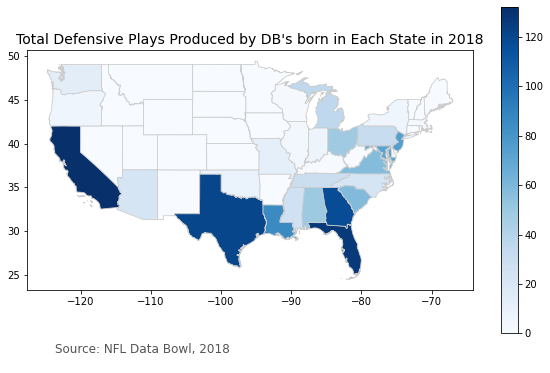

In [466]:
#'homeCity', 'homeState', 'homeCountry', 'highSchool','hsCity', 'hsState', 'hsCountry'
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
df_us = map_df.copy()
df_comb.nflId = df_comb.nflId.astype(int)
filter_on = 'hsState'
df_defense = df_all
title = "Total Defensive Plays Produced by DB's born in Each State in 2018"
font_size = "14"

dict_vals = dict(get_agg(df_defense, filter_on, df_comb,return_dict=True))
df_us['state_count'] = df_us.STUSPS.apply(lambda row: dict_vals[row] if row in dict_vals else 0)
df_us['GEOID'] = df_us['GEOID'].astype(int)
df_temp = df_us[df_us.GEOID < 59]
df_temp = df_temp.reset_index(drop=True)
df_temp = df_temp[~df_temp.NAME.isin(['Hawaii', "Alaska"])]
variable = 'pop_density_per_hectare'

# set the range for the choropleth
vmin, vmax = 0, df_temp.state_count.max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))

df_temp.plot(column='state_count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8',)

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
# add a title
font_size = str(font_size)
ax.set_title(title, fontdict={'fontsize': font_size,'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: NFL Data Bowl, 2018',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
plt.show()

In [478]:
min(def_y)

-2.35

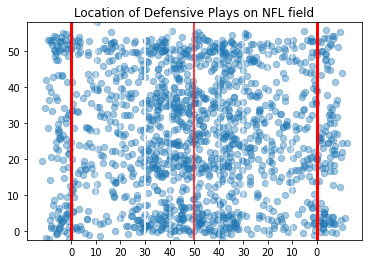

In [734]:
# Interception Locations
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.axvline(x=40,c='white')

def_x = df_all.x.tolist()
def_y = df_all.y.tolist()
plt.plot([10, 10], [min(def_y),max(def_y)], c='red',lw=3) # endzone
plt.plot([110,110], [min(def_y),max(def_y)], c='red', lw=3) # endzone
plt.plot([60,60], [min(def_y),max(def_y)], c='red') # endzone

    

plt.scatter(def_x, def_y, alpha=0.4,s=40)
plt.ylim((min(def_y), max(def_y)))
plt.title("Location of Defensive Plays on NFL field")
plt.xticks([10,20,30,40,50,60,70,80,90,100,110], [0,10,20,30,40,50,40,30,20,10, 0])
# ax.set_facecolor('#6cc067')
ax.grid(axis='x', c='white', alpha=0.4, lw=2)
# plt.figure().set_facecolor('xkcd:salmon')
plt.show()

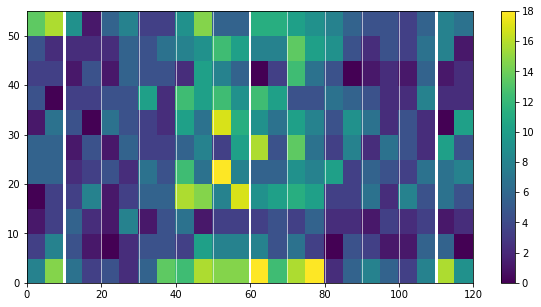

In [713]:

# x2 = np.random.rayleigh(50, size=5000)
# y2 = np.random.rayleigh(50, size=5000)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

plt.plot([10, 10], [min(def_y),max(def_y)], c='white',lw=3) # endzone
plt.plot([110,110], [min(def_y),max(def_y)], c='white', lw=3) # endzone
plt.plot([60,60], [min(def_y),max(def_y)], c='white',lw=2) # endzone
# plt.xticks([10,20,30,40,50,60,70,80,90,100,110], [0,10,20,30,40,50,40,30,20,10, 0])
plt.hist2d(def_x,def_y, bins=[np.arange(0,max(def_x),5),np.arange(0,max(def_y),5)])
# ax.grid(axis='x', c='white', alpha=0.4, lw=2)
for i in range(20,110, 10):
    plt.plot([i,i], [min(def_y),max(def_y)], c='white',lw=1,alpha=0.6) # endzone

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=18))
cbar = fig.colorbar(sm)
plt.show()

In [727]:
count = 0
for r,c in zip(def_x, def_y):
    if r <65 and r >= 60:
        if c <= 5:
            count+=1
count

18

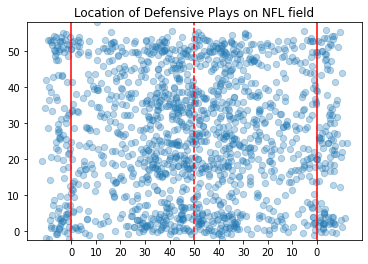

In [735]:
# Interception Locations
def_x = df_all.x.tolist()
def_y = df_all.y.tolist()
plt.plot([10, 10], [min(def_y),max(def_y)], c='red') # endzone
plt.plot([110,110], [min(def_y),max(def_y)], c='red') # endzone
plt.plot([60,60], [min(def_y),max(def_y)], c='red',ls='--') # endzone
plt.scatter(def_x, def_y, alpha=0.3,s=40)
plt.ylim((min(def_y), max(def_y)))
plt.title("Location of Defensive Plays on NFL field")
plt.xticks([10,20,30,40,50,60,70,80,90,100,110], [0,10,20,30,40,50,40,30,20,10, 0])
plt.show()

In [499]:
q = dict(df_int.quarter.value_counts())
d = dict(df_deflections.quarter.value_counts())
d = {k:v for k,v in d.items() if k!=5}
q = {k:q[k] for k in sorted(list(q.keys()))}
d = {k:d[k] for k in sorted(list(d.keys()))}

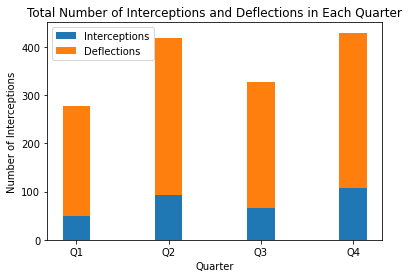

In [500]:
width=0.3
plt.bar(list(q.keys()), list(q.values()), width)
# plt.bar([i+width for i in list(d.keys())], list(d.values()), width, bottom=[q[i] for i in d.keys()])
plt.bar(list(d.keys()), list(d.values()), width, bottom=[q[i] for i in d.keys()])

# plt.xticks([i + width / 2 for i in list(d.keys())], ('Q1', 'Q2', 'Q3', 'Q4'))
plt.xticks([i for i in list(d.keys())], ('Q1', 'Q2', 'Q3', 'Q4'))

plt.xlabel('Quarter')
plt.ylabel('Number of Interceptions')
plt.title('Total Number of Interceptions and Deflections in Each Quarter')
plt.legend(loc='best', labels=('Interceptions', 'Deflections'))
plt.show()

In [ ]:
sns.boxplot(x="nflId", y="PTS", data=df_d_count,
           palette="Set2", 
            order = order)
plt.xlabel("Age Group")
plt.ylabel("Average Points per Game")
plt.title("Boxplot of Average Points Scored for NBA Age Groups in 2019-2020 Season")
plt.show()

In [571]:
# df_deflections

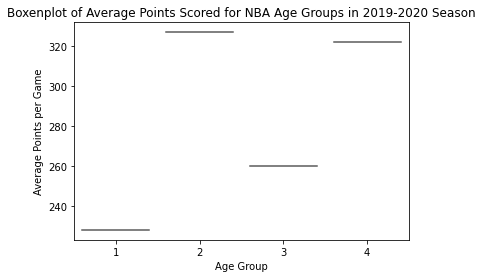

In [565]:
sns.boxenplot(x=list(d.keys()), y=list(d.values()),
           palette="Set2", 
            order = [1,2,3,4])
plt.xlabel("Age Group")
plt.ylabel("Average Points per Game")
plt.title("Boxenplot of Average Points Scored for NBA Age Groups in 2019-2020 Season")
plt.show()

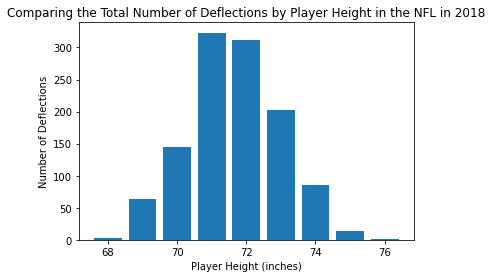

In [504]:
col_val='height'

data, column, df, ylabel,plot, agg = df_deflections, col_val, df_comb, 'Deflections', 'bar', 'sum'
x_vals, y_vals = fun.get_agg(data, column, df)
plt.bar(x_vals, y_vals)
plt.xlabel("Player Height (inches)")
y_final_label = "{} of {}".format(plot,ylabel)
plt.ylabel("Number of Deflections")
plt.title("Comparing the Total Number of Deflections by Player Height in the NFL in 2018")
# plt.title("Comparing {} of {} to {} for NFL Players".format(agg,column, y_final_label))


plt.show()

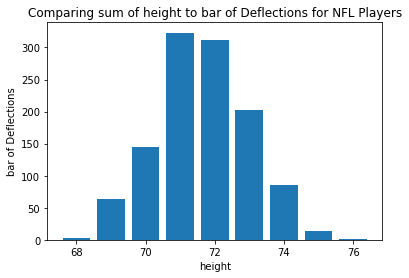

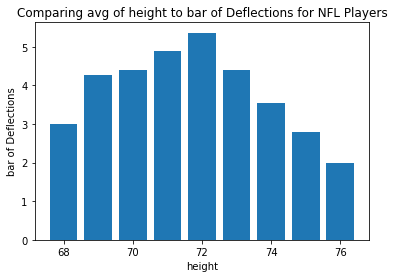

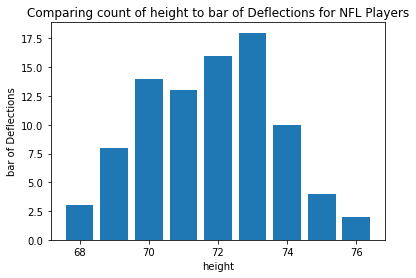

In [298]:
col_val = 'height'
df_db = df_deflections[df_deflections.position.isin(['CB', 'SS', 'FS', 'S', 'DB'])]
fun.plot_points(df_db, col_val, df_comb, 'Deflections', 'bar', 'sum')
fun.plot_points(df_db, col_val, df_comb, "Deflections", 'bar', 'avg')
fun.plot_points(df_db, col_val, df_comb, "Deflections", 'bar', 'count')


In [305]:
df_comb[df_comb.nflId.astype(str).isin(df_db.nflId.tolist())][['combinePosition', 'combine40yd', 'displayName']]

,combinePosition,combine40yd,displayName


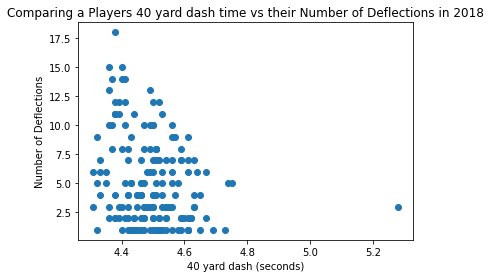

In [545]:
x_column = 'combine40yd'

x_vals, y_vals = get_xy(df_deflections, x_column, df_comb)
plt.scatter(x_vals, y_vals)
plt.ylabel("Number of Deflections")
plt.xlabel("40 yard dash (seconds)")
plt.title("Comparing a Players 40 yard dash time vs their Number of Deflections in 2018")
plt.show()

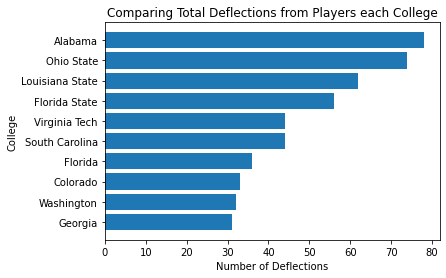

In [228]:
values = fun.get_agg(df_deflections, 'collegeName', df_comb, False)
x_vals, y_vals = [], []
for i in values[-10:]:
    x_vals.append(i[0])
    y_vals.append(i[1])

plt.barh(x_vals, y_vals)
plt.xlabel("Number of Deflections")
plt.ylabel("College")
plt.title("Comparing Total Deflections from Players each College")
plt.show()

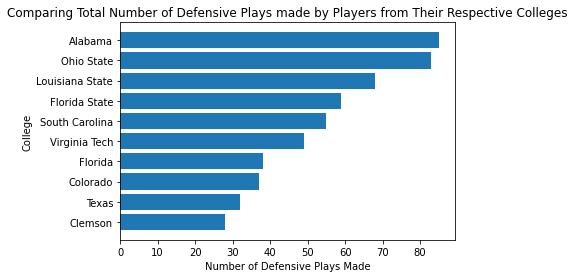

In [547]:
values = get_agg(df_all, 'collegeName', df_comb, avg=False, return_dict=True)
x_vals, y_vals = [], []
for i in values[-10:]:
    x_vals.append(i[0])
    y_vals.append(i[1])

plt.barh(x_vals, y_vals)
plt.xlabel("Number of Defensive Plays Made")
plt.ylabel("College")
plt.title("Comparing Total Number of Defensive Plays made by Players from Their Respective Colleges")
plt.show()

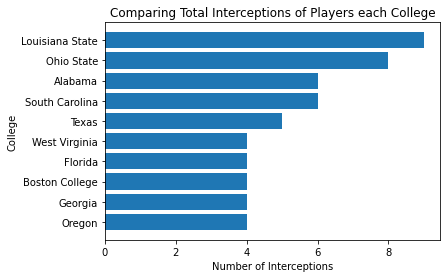

In [831]:
values = fun.get_agg(df_int, 'collegeName', df_comb, avg=False)
x_vals, y_vals = [], []
for i in values[-10:]:
    x_vals.append(i[0])
    y_vals.append(i[1])

plt.barh(x_vals, y_vals)
plt.xlabel("Number of Interceptions")
plt.ylabel("College")
plt.title("Comparing Total Interceptions of Players each College")
plt.show()

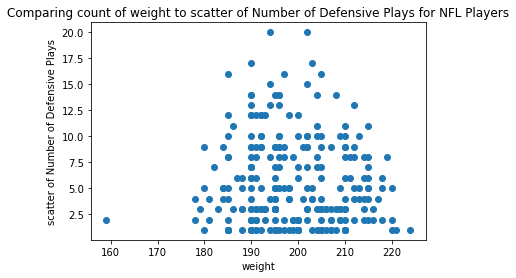

In [559]:
fun.plot_points(df_all, 'weight', df_comb, ylabel='Number of Defensive Plays', plot='scatter',agg='count')

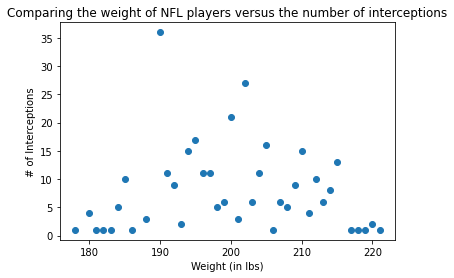

In [368]:
x_vals, y_vals = fun.get_agg(df_int, 'weight', df_comb)
plt.scatter(x_vals, y_vals)
plt.ylabel("# of Interceptions")
plt.xlabel("Weight (in lbs)")
plt.title("Comparing the weight of NFL players versus the number of interceptions")
plt.show()